In [2]:
from model import *
from dscontrol import *
import matplotlib.pyplot as plt
import time

In [7]:
outs = {
    'predict':[],
    'estimated_error':[],
    'exe_time':[]
}
model = FourierGabor(nclusters=3, nbins=50, opening=6, dilation=2)
total = len(DS)
for i, filename in enumerate(DS.filename):
    tic = time.process_time()
    area, error = model.predict(get(filename), True)
    outs['exe_time'].append(time.process_time() - tic)
    outs['predict'].append(area)
    outs['estimated_error'].append(error)
    pi = np.mean(outs['exe_time'])
    et = (total-i)*pi
    print(f'{i+1}/{total}\t{(i/total*100):.2f}%\tPI:{int(pi)}s\tET:{int(et)//60}:{int(et)%60}', end='\r')

In [8]:
dss = pd.concat([DS, pd.DataFrame(outs)], axis=1).sort_values('area', ignore_index=True)
dss['error'] = dss.area - dss.predict
dss['error_rel'] = np.abs(dss.error)/dss.area*100

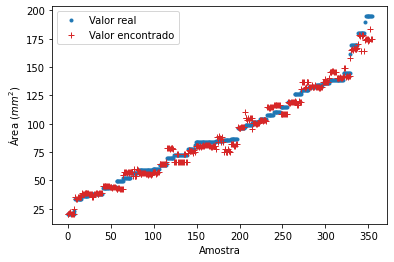

In [9]:
plt.plot(dss.area, '.', label='Valor real')
plt.plot(dss.predict, '+', c='tab:red', label='Valor encontrado', lw=0.7)
plt.ylabel(r'Área ($mm^2$)')
plt.xlabel('Amostra')
plt.legend()
plt.show()

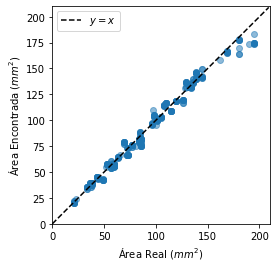

In [10]:
fig, ax = plt.subplots()
plt.plot(dss.area, dss.predict, 'o', alpha=0.5)
ax.set_aspect('equal', 'box')
plt.xlim(0, 210)
plt.ylim(0, 210)
plt.xlabel(r'Área Real ($mm^2$)')
plt.ylabel(r'Área Encontrada ($mm^2$)')
plt.plot(np.arange(0, 210), 'k--', label=r'$y=x$')
plt.legend()
plt.show()

In [11]:
dss.error_rel.describe()

count    355.000000
mean       4.449264
std        3.482125
min        0.195992
25%        1.337837
50%        4.251598
75%        6.176334
max       14.237971
Name: error_rel, dtype: float64

In [13]:
dss.exe_time.describe()

count    355.000000
mean       4.596347
std        2.280429
min        2.218750
25%        3.476562
50%        4.093750
75%        5.000000
max       18.015625
Name: exe_time, dtype: float64

In [14]:
dss.to_csv('dss_predict.csv', index=False)

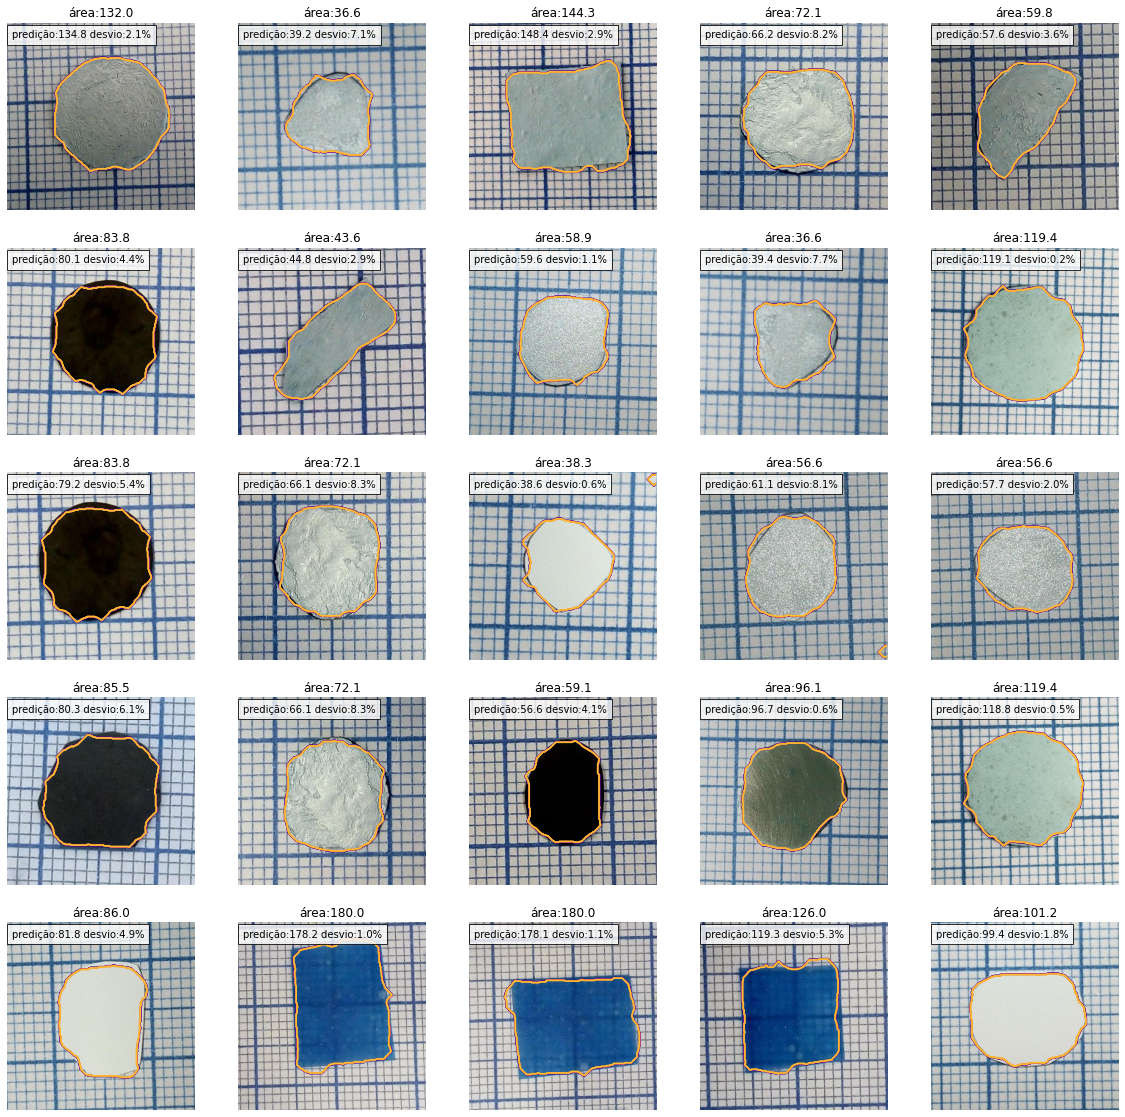

In [149]:
n = 5
r = 5
fig, axs = plt.subplots(r, n, figsize=(4*n, 4*r))
axs = axs.flatten()

for i, (image, name) in enumerate(zip(*random_images(r*n, names=True))):
    #print(name, end=', ')
    
    img = rgb2gray(image)
    
    _, angles, _ = hough_line_peaks(*hough_line(canny(img), np.linspace(-np.pi/2, np.pi/2, 500)))
    slopes = np.degrees(angles + np.pi/2)
    slope_values = np.unique(slopes)
    probs = np.array([np.sum(slopes == val)/len(slopes) for val in slope_values])
    img_slope = slope_values[probs == probs.max()][0]
    img = rotate(img, img_slope, mode='reflect')
    
    Fx = np.apply_along_axis(pixel_scale_1d, 0, image)
    Fy = np.apply_along_axis(pixel_scale_1d, 1, image)
    fx, fy = np.median(Fx[Fx > 0.025]), np.median(Fy[Fy > 0.025])
    std_fx, std_fy = np.std(Fx[Fx > 0.025]), np.std(Fy[Fy > 0.025])
    
    #imgrr = rgb2gray(rgb2hsv(rotate(image, img_slope, mode='reflect')))
    xreal, ximag = gabor(img, fx, 0, n_stds=3)
    yreal, yimag = gabor(img, fy, np.pi/2, n_stds=3)
    filtered = np.sqrt(xreal**2 + ximag**2) + np.sqrt(yreal**2 + yimag**2)
    
    #filtered = nd.minimum_filter(filtered, footprint=disk(5))
    #filtered = nd.median_filter(filtered, footprint=disk(5))

    mask = filtered < threshold_kmeans(filtered) #threshold_isodata(filtered, nbins=100)
    mask = nd.binary_opening(mask, iterations=6)
    #mask = nd.binary_closing(mask, iterations=4)
    mask = nd.binary_dilation(mask, iterations=2)
    mask = rotate(mask, -img_slope)
    
    axs[i].imshow(image)
    axs[i].contour(mask, cmap='plasma')
    
    area = float(DS.loc[DS.filename == name].area)
    area_pixel = np.sum(mask)
    predict = area_pixel*fx*fy
    error = np.sqrt(
        (area_pixel*fy*std_fx)**2 +
        (area_pixel*fx*std_fy)**2
    )
    
    axs[i].set_title(f'área:{area:.1f}')
    axs[i].text(6, 20, 'predição:{p:.1f} desvio:{d:.1f}%'.format(p=predict, d=(np.abs(area-predict)/area*100)),
               bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    axs[i].axis('off')
    #axs[i].legend()
    
plt.show()